In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import scarches

from anndata import AnnData
from scarches.models.scpoli import scPoli

import umap

INFO:pytorch_lightning.utilities.seed:Global seed set to 0
/dss/dsshome1/06/di93vel/.conda/envs/heoa_venv/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/dss/dsshome1/06/di93vel/.conda/envs/heoa_venv/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)
 captum (see https://github.com/pytorch/captum).


In [2]:
import torch
print(torch.cuda.is_available())

False


## Specify working directory

In [3]:
WD = "/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93vel/atlas_building"

## Functions

In [146]:
def get_counts(adata):
    t = adata.X.toarray()
    data_df = pd.DataFrame(data=t, index=adata.obs_names, columns=adata.var_names)
    data_df = np.expm1(data_df)
    counts_df = data_df.T.mul(adata.obs.n_counts).div(10000)
    counts_df = counts_df.T.iloc[:,:]
    counts_df = counts_df.round(0).astype(np.float32)
    return counts_df

def get_kwargs():
    early_stopping_kwargs = {
        "early_stopping_metric": "val_prototype_loss",
        "mode": "min",
        "threshold": 0,
        "patience": 20,
        "reduce_lr": True,
        "lr_patience": 13,
        "lr_factor": 0.1,
    }
    return early_stopping_kwargs

def train_scpoli(adata, condition_key):
    early_stopping_kwargs = get_kwargs()

    scpoli_model = scPoli(
        adata=adata,
        unknown_ct_names=['na'],
        condition_keys=[condition_key],
        cell_type_keys=['predict_level_2_late'],
        embedding_dims=10,  # default
        latent_dim=10,  # default
        # hidden_layer_sizes=[512, 512],
        recon_loss='mse',
    )

    scpoli_model.train(
        n_epochs=20,
        pretraining_epochs=16,
        early_stopping_kwargs=early_stopping_kwargs,
        eta=10,
    )

    return scpoli_model


## Load samples

In [126]:
project_dir = os.path.join(WD, 'data')

### Load CRC data

In [127]:
crc = sc.read(os.path.join(project_dir, 'adata_crc.h5ad'))
crc

AnnData object with n_obs × n_vars = 1832 × 2000
    obs: 'sample_id', 'condition', 'batch', 'level_1', 'level_2', 'level_3', 'predict_level_1_late', 'predict_level_2_late', 'predict_tissue', 'mean_dist'
    uns: 'log1p'
    obsm: 'X_umap'
    layers: 'counts'

In [128]:
crc.obs['condition'].value_counts()

cancer    1192
normal     640
Name: condition, dtype: int64

In [129]:
crc.obs['predict_level_2_late'].value_counts()

colonocytes              878
stem cells               728
goblet cells             176
mesothelial cells         19
biliary cells              8
enterocytes                7
stellate cells             7
enteroendocrine cells      5
tuft cells                 2
hepatocytes                1
neuron                     1
Name: predict_level_2_late, dtype: int64

In [130]:
print(np.max(crc.X))
print(np.min(crc.X))
print(type(crc.X[0,0]))

7.7649236
0.0
<class 'numpy.float32'>


### Load COPD data

In [138]:
copd = sc.read(os.path.join(project_dir, 'adata_copd.h5ad'))
copd

AnnData object with n_obs × n_vars = 20316 × 2000
    obs: 'sample_id', 'tissue', 'status', 'status_fine', 'batch', 'level_1', 'level_2', 'level_3', 'predict_level_1_late', 'predict_level_2_late', 'predict_tissue', 'mean_dist'
    var: 'gene_ids-0', 'feature_types-0'
    obsm: 'X_umap'
    layers: 'counts'

In [139]:
copd.obs['status_fine'].value_counts()

COPD bronchial (query)            7720
Healthy bronchial (query)         4846
Healthy nasopharyngeal (query)    4050
COPD nasopharyngeal (query)       3700
Name: status_fine, dtype: int64

In [140]:
copd.obs['predict_level_2_late'].value_counts()

club cells                     12068
basal cells                     7089
ciliated cells                   970
alveolar type 1 (AT1) cells      126
stem cells                        38
acinar cells                      11
cardiovascular cells               3
mesoderm 1 (HAND1)                 3
alveolar type 2 (AT2) cells        2
cycling endothelial cells          1
ductal cells                       1
goblet cells                       1
luminal cells                      1
smooth muscle cells (SMC)          1
thyrocytes                         1
Name: predict_level_2_late, dtype: int64

In [141]:
print(np.max(copd.X))
print(np.min(copd.X))
print(type(copd.X[0,0]))

8.586012
0.0
<class 'numpy.float32'>


## Integrate CRC data

In [131]:
crc_model = train_scpoli(crc, 'condition')

Embedding dictionary:
 	Num conditions: [2]
 	Embedding dim: [10]
Encoder Architecture:
	Input Layer in, out and cond: 2000 45 10
	Mean/Var Layer in/out: 45 10
Decoder Architecture:
	First Layer in, out and cond:  10 45 10
	Output Layer in/out:  45 2000 

Initializing dataloaders
Starting training
 |████████████████----| 80.0%  - val_loss:  194.52 - val_cvae_loss:  194.52
Initializing unlabeled prototypes with Leiden with an unknown number of  clusters.
Clustering succesful. Found 18 clusters.
 |████████████████████| 100.0%  - val_loss:  217.58 - val_cvae_loss:  189.84 - val_prototype_loss:   27.74 - val_unlabeled_loss:    1.52 - val_labeled_loss:    2.77


In [132]:
crc.obsm['X_scPoli'] = crc_model.get_latent(
    crc,
    mean=True,
)

In [133]:
# visualize the latent representation of CRC cells computed by scPoli
sc.pp.neighbors(crc, use_rep='X_scPoli')
sc.tl.umap(crc)

/dss/dsshome1/06/di93vel/.conda/envs/heoa_venv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/dss/dsshome1/06/di93vel/.conda/envs/heoa_venv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


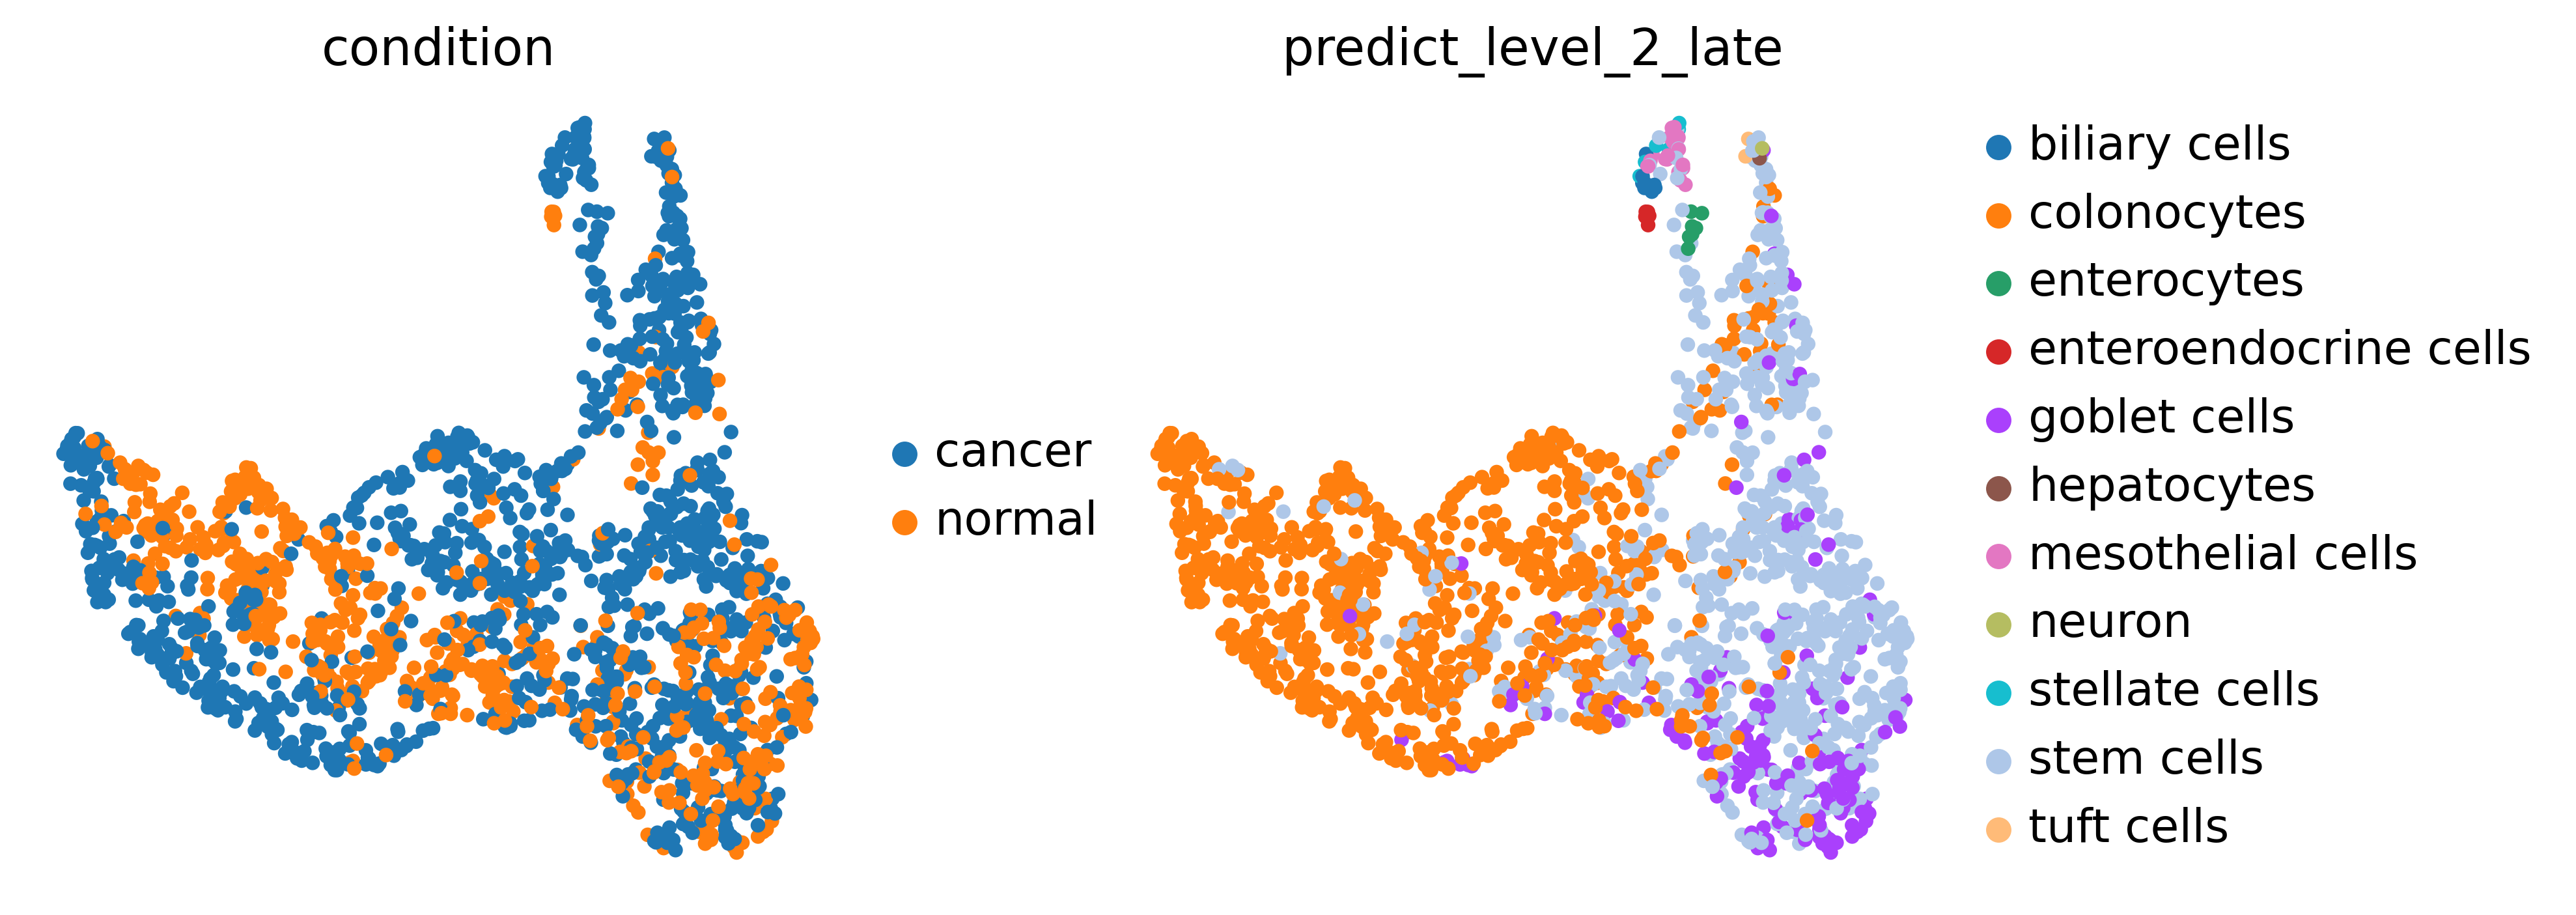

In [137]:
sc.pl.umap(
    crc, 
    color=['condition', 'predict_level_2_late'],
    show=True,
    frameon=False,
    # save=f'_scPoli_latent_crc.png',
)

In [142]:
crc

AnnData object with n_obs × n_vars = 1832 × 2000
    obs: 'sample_id', 'condition', 'batch', 'level_1', 'level_2', 'level_3', 'predict_level_1_late', 'predict_level_2_late', 'predict_tissue', 'mean_dist', 'conditions_combined'
    uns: 'log1p', 'neighbors', 'umap', 'condition_colors', 'predict_level_2_late_colors'
    obsm: 'X_umap', 'X_scPoli'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [143]:
crc.obs.drop(columns=['conditions_combined'], inplace=True)
crc.write(os.path.join(project_dir, f'integrated_crc.h5ad'))

## Integrate COPD data

In [147]:
copd_model = train_scpoli(copd, 'status_fine')

Embedding dictionary:
 	Num conditions: [4]
 	Embedding dim: [10]
Encoder Architecture:
	Input Layer in, out and cond: 2000 45 10
	Mean/Var Layer in/out: 45 10
Decoder Architecture:
	First Layer in, out and cond:  10 45 10
	Output Layer in/out:  45 2000 

Initializing dataloaders
Starting training
 |████████████████----| 80.0%  - val_loss:  184.47 - val_cvae_loss:  184.47
Initializing unlabeled prototypes with Leiden with an unknown number of  clusters.
Clustering succesful. Found 27 clusters.
 |████████████████████| 100.0%  - val_loss:  203.74 - val_cvae_loss:  189.82 - val_prototype_loss:   13.92 - val_unlabeled_loss:    1.58 - val_labeled_loss:    1.39


In [148]:
copd.obsm['X_scPoli'] = copd_model.get_latent(
    copd,
    mean=True,
)

In [149]:
# visualize the latent representation of COPD cells computed by scPoli
sc.pp.neighbors(copd, use_rep='X_scPoli')
sc.tl.umap(copd)

/dss/dsshome1/06/di93vel/.conda/envs/heoa_venv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/dss/dsshome1/06/di93vel/.conda/envs/heoa_venv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


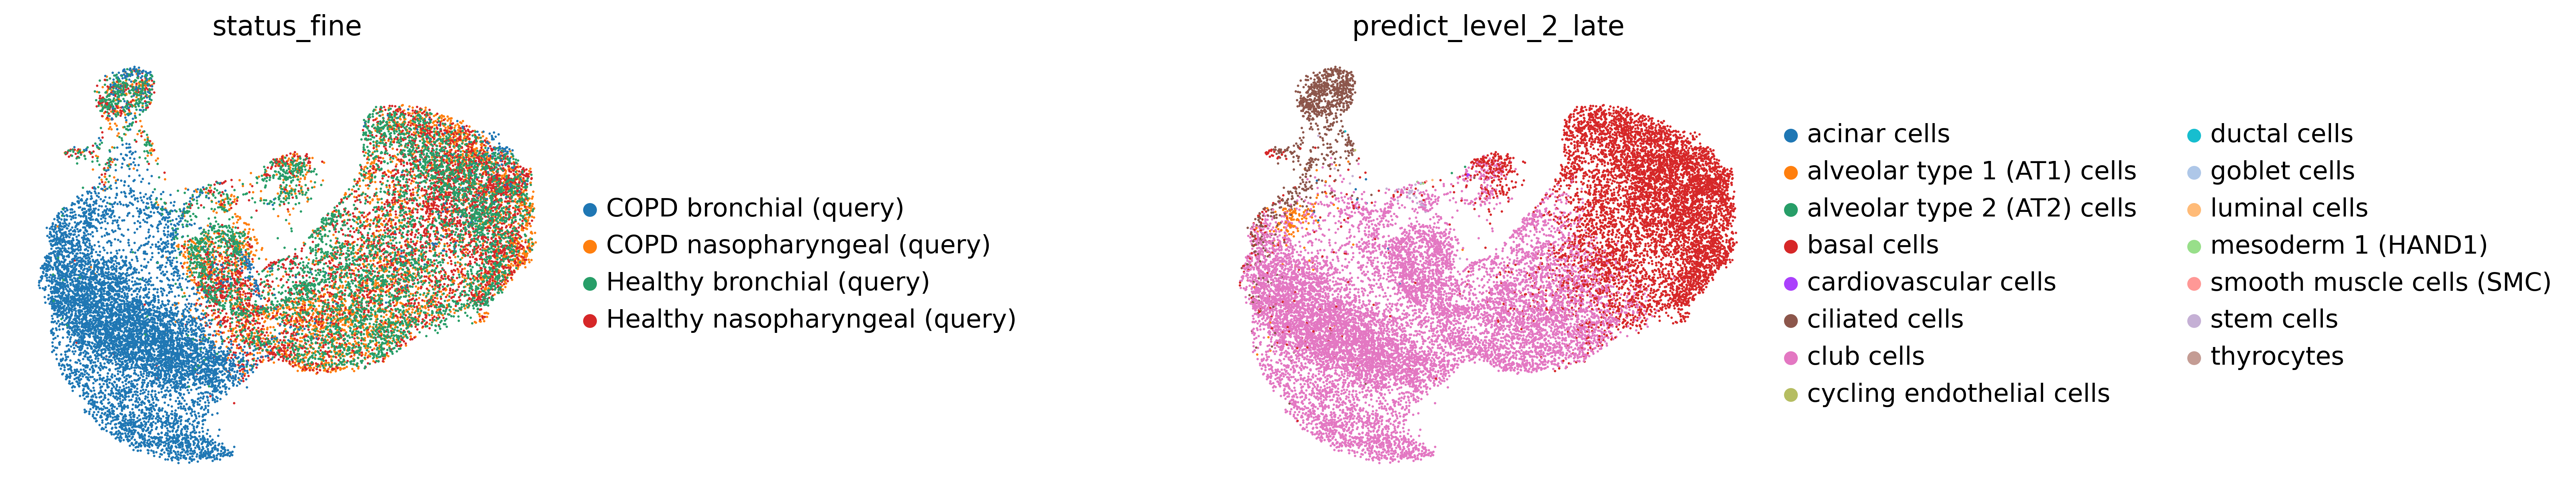

In [ ]:
sc.pl.umap(
    copd, 
    color=['status_fine', 'predict_level_2_late'],
    show=True,
    frameon=False,
    wspace=1,
    # save=f'_scPoli_latent_copd.png',
)

In [153]:
copd

AnnData object with n_obs × n_vars = 20316 × 2000
    obs: 'sample_id', 'tissue', 'status', 'status_fine', 'batch', 'level_1', 'level_2', 'level_3', 'predict_level_1_late', 'predict_level_2_late', 'predict_tissue', 'mean_dist', 'conditions_combined'
    var: 'gene_ids-0', 'feature_types-0'
    uns: 'neighbors', 'umap', 'status_fine_colors', 'predict_level_2_late_colors'
    obsm: 'X_umap', 'X_scPoli'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [154]:
copd.obs.drop(columns=['conditions_combined'], inplace=True)
copd.write(os.path.join(project_dir, f'integrated_copd.h5ad'))